# Práctica Multiobjetivo – ZDT3

In [1]:
import numpy as np
import random, copy
import pandas as pd
import matplotlib.pyplot as plt

from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.indicators.hv import Hypervolume


problem = get_problem('zdt3')
N_VAR = problem.n_var
XL, XU = problem.xl, problem.xu

BUDGET = 10_000
POP_SIZE = 100
N_GEN = BUDGET // POP_SIZE


## Introducción

**ZDT3** es un problema multiobjetivo clásico que consta de treinta variables con un frente de Pareto separable. Donde se trata de minimizar simultáneamente f 1 y h.

En esta práctica se utiliza la configuración estándar indicada en el enunciado:

* Número de funciones objetivo: 2
* Número de variables de decisión: 30
* Dominio de las variables: [0, 1]
* Presupuesto máximo de evaluaciones: 10 000

El objetivo adaptar el ag y analizar el comportamiento de distintos algoritmos evolutivos multiobjetivo bajo un presupuesto limitado.


## Funciones auxiliares: evaluación, Pareto (ranks) y crowding distance

En este bloque se definen las funciones básicas necesarias para la evaluación y selección multiobjetivo.

- La función `eval_pop` evalúa una población completa y devuelve los valores de las funciones objetivo.
- La función `nd_ranks` realiza el ordenamiento por no dominancia, asignando a cada individuo un rango según el frente de Pareto al que pertenece, siendo el rango 0 el correspondiente al frente no dominado.
- La función `crowding_distance` calcula la distancia de crowding de un frente, que se utiliza como criterio de diversidad para favorecer soluciones bien distribuidas a lo largo del frente de Pareto.

In [2]:
def eval_pop(X):
    # Evaluación de la población
    return problem.evaluate(X, return_values_of=['F'])


def nd_ranks(F):
    # Obtención de frentes no dominados
    nds = NonDominatedSorting()
    fronts = nds.do(F)

    # Asignación del rango de cada individuo
    rank = np.empty(len(F), dtype=int)
    for r, front in enumerate(fronts):
        rank[front] = r

    return fronts, rank


def crowding_distance(F_front):
    # Cálculo de diversidad en un frente
    k = len(F_front)

    # Casos triviales
    if k == 0:
        return np.array([])
    if k <= 2:
        return np.full(k, np.inf)

    # Inicialización de variables
    m = F_front.shape[1]
    cd = np.zeros(k, dtype=float)

    # Contribución de cada objetivo
    for j in range(m):
        order = np.argsort(F_front[:, j])

        # Preservación de extremos
        cd[order[0]] = np.inf
        cd[order[-1]] = np.inf

        # Normalización
        fmin = F_front[order[0], j]
        fmax = F_front[order[-1], j]
        if fmax == fmin:
            continue

        # Acumulación de distancias
        for t in range(1, k - 1):
            if np.isinf(cd[order[t]]):
                continue
            prevv = F_front[order[t - 1], j]
            nextv = F_front[order[t + 1], j]
            cd[order[t]] += (nextv - prevv) / (fmax - fmin)

    return cd

## Métricas de evaluación

En este bloque se definen las métricas utilizadas para comparar el rendimiento de los algoritmos multiobjetivo:

* Hipervolumen (HV), que mide simultáneamente convergencia y diversidad. El punto de referencia del hipervolumen se calcula de forma dinámica, tomando el peor valor observado en cada objetivo y añadiendo un pequeño margen, con el fin de evitar valores nulos debidos a una mala elección del punto de referencia.
* Dispersión (SPR), que cuantifica la extensión del frente obtenido.
* Espaciado (SPA), que evalúa la uniformidad del frente, siendo valores menores indicativos de una mejor distribución.


In [3]:
def make_ref_point(fronts, margin=0.1):
    # Construcción del punto de referencia a partir de los frentes
    allF = np.vstack(fronts)
    ref = np.max(allF, axis=0) + margin
    return ref


def calculate_metrics(front, ref_point):
    # Selección de soluciones dentro del punto de referencia
    inside = np.all(front <= ref_point, axis=1)
    front_in = front[inside]

    # Cálculo del hipervolumen
    if len(front_in) == 0:
        hv = 0.0
    else:
        hv = Hypervolume(ref_point).do(front_in)

    # Cálculo de la extensión del frente
    min_values = np.min(front, axis=0)
    max_values = np.max(front, axis=0)
    spr = np.linalg.norm(max_values - min_values)

    # Cálculo del spacing
    if len(front) < 2:
        spa = np.inf
    else:
        d = np.linalg.norm(front[:, None, :] - front[None, :, :], axis=-1)
        np.fill_diagonal(d, np.inf)
        spa = np.mean(np.min(d, axis=1))

    return hv, spr, spa

## Algoritmos de referencia

En este bloque se implementan NSGA-II y SPEA2 mediante la librería `pymoo`, que se utilizan como algoritmos de referencia.

- NSGA-II combina el ordenamiento por no dominancia con la distancia de crowding para mantener la diversidad del frente, aplicando un esquema de selección elitista.
- SPEA2 emplea un mecanismo de asignación de fuerza y una población externa de élite, lo que permite una presión selectiva alternativa y una buena distribución de soluciones.

Ambos algoritmos se ejecutan bajo el mismo presupuesto de evaluaciones y configuración de operadores (estándar), manteniendo una comparación justa.

In [4]:
def run_nsga2(seed=0, pop_size=POP_SIZE, n_gen=N_GEN):
    algo = NSGA2(
        pop_size=pop_size,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(prob=1.0/N_VAR, eta=20),
        eliminate_duplicates=True
    )
    res = minimize(problem, algo, ('n_gen', n_gen), seed=seed, verbose=False)
    F = res.pop.get('F')
    nd = NonDominatedSorting().do(F, only_non_dominated_front=True)
    return {"F": F, "F_nd": F[nd]}

def run_spea2(seed=0, pop_size=POP_SIZE, n_gen=N_GEN):
    algo = SPEA2(
        pop_size=pop_size,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(prob=1.0/N_VAR, eta=20),
        eliminate_duplicates=True
    )
    res = minimize(problem, algo, ('n_gen', n_gen), seed=seed, verbose=False)
    F = res.pop.get('F')
    nd = NonDominatedSorting().do(F, only_non_dominated_front=True)
    return {"F": F, "F_nd": F[nd]}


## Algoritmo genético multiobjetivo adaptado

En este bloque se implementa un algoritmo genético multiobjetivo adaptado, basado en los principios de selección de NSGA-II, pero con operadores propios.

* La población inicial se genera aleatoriamente dentro del dominio del problema.
* La evaluación de los individuos se realiza mediante las funciones objetivo del problema.
* La selección se basa en:
  * Ordenamiento por no dominancia.
  * Cálculo de la distancia de crowding.
  * Torneo binario para la elección de progenitores.
* En esta primera versión se utilizan:
  * **Cruce aritmético**.
  * **Mutación gaussiana**.
* La selección ambiental es elitista, preservando las mejores soluciones y manteniendo la diversidad del frente.

In [5]:
def create_population_mo(pop_size=POP_SIZE):
    return np.random.uniform(XL, XU, size=(pop_size, N_VAR))

def arithmetic_crossover_vec(p1, p2, pcross=0.9):
    if random.random() > pcross:
        return p1.copy(), p2.copy()
    alpha = random.random()
    c1 = alpha * p1 + (1 - alpha) * p2
    c2 = (1 - alpha) * p1 + alpha * p2
    return c1, c2

def gaussian_mutation_vec(x, pmut=None, sigma=0.1):
    if pmut is None:
        pmut = 1.0 / N_VAR
    y = x.copy()
    for i in range(len(y)):
        if random.random() < pmut:
            y[i] += random.gauss(0, sigma)
    return np.clip(y, XL, XU)

def environmental_selection(pop, F, pop_size=POP_SIZE):
    # ordenación por frentes + crowding distance
    fronts, rank = nd_ranks(F)

    # Construcción de la nueva población
    new_idx = []
    crowd = np.zeros(len(pop), dtype=float)

    for front in fronts:
        # Inclusión completa del frente si cabe
        if len(new_idx) + len(front) <= pop_size:
            cd = crowding_distance(F[front])
            crowd[front] = cd
            new_idx.extend(front.tolist())
        else:
            # Relleno parcial del último frente usando crowding distance
            cd = crowding_distance(F[front])
            crowd[front] = cd
            remaining = pop_size - len(new_idx)

            # Selección de los más diversos dentro del frente
            order = np.argsort(-cd)
            chosen = front[order[:remaining]]
            new_idx.extend(chosen.tolist())
            break

    new_idx = np.array(new_idx, dtype=int)
    return pop[new_idx], F[new_idx], rank[new_idx], crowd[new_idx]

def tournament_select(pop, rank, crowd):
    i, j = random.randrange(len(pop)), random.randrange(len(pop))
    if rank[i] < rank[j]:
        return pop[i]
    if rank[j] < rank[i]:
        return pop[j]
    # Desempate por diversidad
    return pop[i] if crowd[i] > crowd[j] else pop[j]

def evolve_my_mo(seed=0, pop_size=POP_SIZE, n_gen=N_GEN, pcross=0.9, pmut=None, sigma=0.1):
    random.seed(seed)
    np.random.seed(seed)

    # Inicialización y evaluación inicial
    pop = create_population_mo(pop_size)
    F = eval_pop(pop)
    evals = pop_size

    # Rank y crowding inicial para poder seleccionar padres
    pop, F, rank, crowd = environmental_selection(pop, F, pop_size)

    for _ in range(n_gen):
        # Generación de descendencia mediante selección + cruce + mutación
        children = []
        while len(children) < pop_size:
            p1 = tournament_select(pop, rank, crowd)
            p2 = tournament_select(pop, rank, crowd)
            c1, c2 = arithmetic_crossover_vec(p1, p2, pcross)
            c1 = gaussian_mutation_vec(c1, pmut=pmut, sigma=sigma)
            c2 = gaussian_mutation_vec(c2, pmut=pmut, sigma=sigma)
            children.append(c1)
            if len(children) < pop_size:
                children.append(c2)

        # Evaluación de la nueva población generada
        children = np.array(children)
        Fc = eval_pop(children)
        evals += pop_size

        # Unión padres + hijos y selección ambiental para mantener tamaño fijo
        pop = np.vstack([pop, children])
        F = np.vstack([F, Fc])
        pop, F, rank, crowd = environmental_selection(pop, F, pop_size)

    nd = NonDominatedSorting().do(F, only_non_dominated_front=True)
    return {"pop": pop,"F": F,"F_nd": F[nd],"evals": evals}

## Experimento único

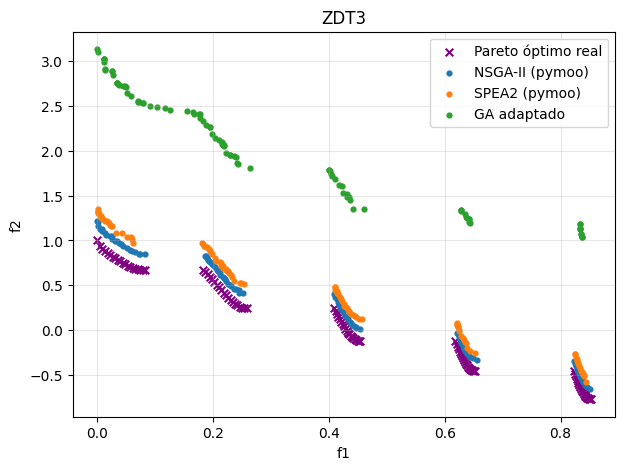

In [6]:
seed = 0

my = evolve_my_mo(seed=seed)
ns = run_nsga2(seed=seed)
sp = run_spea2(seed=seed)

# Frente de Pareto real de ZDT3
pareto_optimal = problem.pareto_front()

plt.figure(figsize=(7,5))

# Pareto óptimo real
plt.scatter(
    pareto_optimal[:, 0], pareto_optimal[:, 1],
    color="purple", s=30, marker="x",
    label="Pareto óptimo real"
)

# Algoritmos
plt.scatter(ns["F_nd"][:,0], ns["F_nd"][:,1],
            s=12, label="NSGA-II (pymoo)")
plt.scatter(sp["F_nd"][:,0], sp["F_nd"][:,1],
            s=12, label="SPEA2 (pymoo)")
plt.scatter(my["F_nd"][:,0], my["F_nd"][:,1],
            s=12, label="GA adaptado")

plt.xlabel("f1")
plt.ylabel("f2")
plt.title("ZDT3")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Múltiples experimentos

In [7]:
rows = []

for seed in range(10):
    ag = evolve_my_mo(seed=seed, sigma=0.05)
    ns = run_nsga2(seed)
    sp = run_spea2(seed)

    ref_point = make_ref_point([ag["F_nd"], ns["F_nd"], sp["F_nd"]], margin=0.1)

    hv_ag, spr_ag, spa_ag = calculate_metrics(ag["F_nd"], ref_point)
    hv_n,  spr_n,  spa_n  = calculate_metrics(ns["F_nd"], ref_point)
    hv_s,  spr_s,  spa_s  = calculate_metrics(sp["F_nd"], ref_point)

    rows.append({
        "seed": seed,
        "ref_f1": ref_point[0], "ref_f2": ref_point[1],
        "HV_AG": hv_ag, "SPR_AG": spr_ag, "SPA_AG": spa_ag,
        "HV_NSGA2": hv_n, "SPR_NSGA2": spr_n, "SPA_NSGA2": spa_n,
        "HV_SPEA2": hv_s, "SPR_SPEA2": spr_s, "SPA_SPEA2": spa_s
    })

df = pd.DataFrame(rows)
df

,seed,ref_f1,ref_f2,HV_AG,SPR_AG,SPA_AG,HV_NSGA2,SPR_NSGA2,SPA_NSGA2,HV_SPEA2,SPR_SPEA2,SPA_SPEA2
0,0,0.950218,3.967752,1.649168,2.583527,0.017505,3.632883,2.057442,0.013968,3.537968,2.115626,0.014077
1,1,0.952626,3.977531,1.618734,2.600864,0.018237,3.514265,2.119788,0.014620,3.585832,2.087460,0.015027
2,2,0.953344,3.823111,1.445625,2.176959,0.012165,3.422074,2.105969,0.014754,3.527488,2.008224,0.014863
3,3,0.954631,4.511955,1.830944,2.810783,0.016235,4.217382,2.031596,0.014105,4.146843,2.079666,0.015616
4,4,0.954895,4.209307,1.595110,2.465726,0.014403,3.886794,2.052401,0.015408,3.818810,2.069222,0.015139
5,5,0.951609,4.128271,1.546487,2.107070,0.012343,3.773919,2.065700,0.014888,3.763402,2.084197,0.014903
6,6,0.950812,4.441505,1.613202,2.488305,0.014611,3.954612,2.110584,0.015628,4.046344,2.093946,0.013738
7,7,0.951663,4.162194,1.596434,2.386079,0.015559,3.720447,2.117134,0.016005,3.828279,2.025020,0.014874
8,8,0.954522,3.911327,1.520711,2.024783,0.012797,3.490657,2.087438,0.013596,3.562535,2.092699,0.013133
9,9,0.951285,4.222637,1.575100,2.504513,0.017646,3.873018,2.055565,0.014684,3.821056,2.090941,0.015584


### Estadísticas (media y desviación típica)

In [8]:
summary_hv_spa = df[[
    "HV_AG", "SPA_AG",
    "HV_NSGA2", "SPA_NSGA2",
    "HV_SPEA2", "SPA_SPEA2"
]].agg(["mean", "std"])

summary_hv_spa

,HV_AG,SPA_AG,HV_NSGA2,SPA_NSGA2,HV_SPEA2,SPA_SPEA2
mean,1.599152,0.015150,3.748605,0.014766,3.763856,0.014696
std,0.099950,0.002257,0.244873,0.000758,0.215004,0.000802


## Mejor experimento de AG

Best seed (AG) = 3


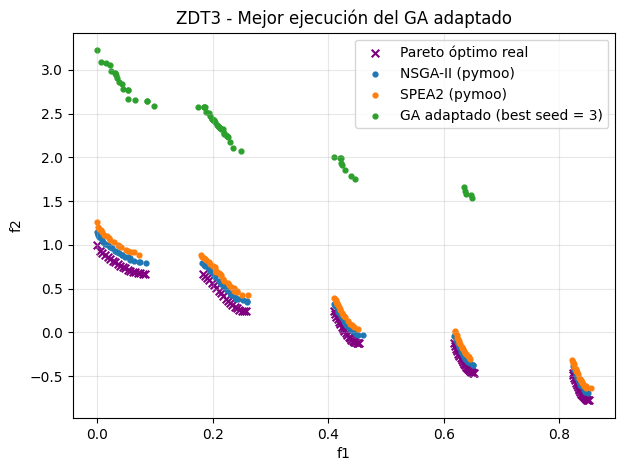

In [9]:
best_seed = int(df.loc[df["HV_AG"].idxmax(), "seed"])
print("Best seed (AG) =", best_seed)

my = evolve_my_mo(seed=best_seed)
ns = run_nsga2(seed=best_seed)
sp = run_spea2(seed=best_seed)

# Pareto óptimo real
pareto_optimal = problem.pareto_front()

plt.figure(figsize=(7,5))

# Pareto real
plt.scatter(
    pareto_optimal[:, 0], pareto_optimal[:, 1],
    color="purple", marker="x", s=30,
    label="Pareto óptimo real"
)

# Algoritmos
plt.scatter(ns["F_nd"][:,0], ns["F_nd"][:,1], s=12, label="NSGA-II (pymoo)")
plt.scatter(sp["F_nd"][:,0], sp["F_nd"][:,1], s=12, label="SPEA2 (pymoo)")
plt.scatter(my["F_nd"][:,0], my["F_nd"][:,1], s=12,
            label=f"GA adaptado (best seed = {best_seed})")

plt.xlabel("f1")
plt.ylabel("f2")
plt.title("ZDT3 - Mejor ejecución del GA adaptado")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## GA v2: sustitución de operadores (SBX + mutación polinómica)

En este bloque se presenta una segunda versión del algoritmo genético multiobjetivo adaptado, en la que se modifican los operadores evolutivos, manteniendo sin cambios el esquema de selección y la estructura general del algoritmo.

* Se conserva el mismo mecanismo de:

  * Ordenamiento por no dominancia.
  * Cálculo de la distancia de crowding.
  * Torneo binario para la selección de progenitores.
  * Selección ambiental elitista.

* En esta versión se sustituyen los operadores de la versión anterior por:
  * Cruce SBX (Simulated Binary Crossover)
  * Mutación polinómica, que permite realizar perturbaciones controladas en las variables.
* Se introduce un pequeño mecanismo de reinyección aleatoria de individuos, con el objetivo de mejorar la diversidad del frente en problemas con frentes discontinuos como ZDT3.
* El algoritmo se ejecuta bajo el mismo presupuesto máximo de evaluaciones para una comparación directa con la versión v1 y con los algoritmos de referencia.

In [10]:
def sbx_crossover_vec(p1, p2, pcross=0.9, eta=15):
    if random.random() > pcross:
        return p1.copy(), p2.copy()

    n = len(p1)
    c1 = p1.copy()
    c2 = p2.copy()

    # Aplicación del cruce gen a gen
    for i in range(n):
        u = random.random()
        if u <= 0.5:
            beta = (2*u) ** (1/(eta+1))
        else:
            beta = (1/(2*(1-u))) ** (1/(eta+1))

        c1[i] = 0.5*((1+beta)*p1[i] + (1-beta)*p2[i])
        c2[i] = 0.5*((1-beta)*p1[i] + (1+beta)*p2[i])

    # Reparación por límites
    return np.clip(c1, XL, XU), np.clip(c2, XL, XU)


def polynomial_mutation_vec(x, pmut=None, eta=20):
    if pmut is None:
        pmut = 1.0 / N_VAR

    y = x.copy()

    # Mutación independiente por variable
    for i in range(len(y)):
        if random.random() < pmut:

            # Límites por variable
            xl_i = XL[i] if np.ndim(XL) > 0 else XL
            xu_i = XU[i] if np.ndim(XU) > 0 else XU

            if xu_i <= xl_i:
                continue

            u = random.random()

            delta1 = (y[i] - xl_i) / (xu_i - xl_i)
            delta2 = (xu_i - y[i]) / (xu_i - xl_i)

            # Cálculo del desplazamiento mutacional
            if u < 0.5:
                xy = 1.0 - delta1
                val = 2.0*u + (1.0 - 2.0*u) * (xy ** (eta + 1))
                deltaq = (val ** (1.0 / (eta + 1))) - 1.0
            else:
                xy = 1.0 - delta2
                val = 2.0*(1.0 - u) + 2.0*(u - 0.5) * (xy ** (eta + 1))
                deltaq = 1.0 - (val ** (1.0 / (eta + 1)))

            y[i] = y[i] + deltaq * (xu_i - xl_i)

    if np.ndim(XL) > 0:
        return np.minimum(np.maximum(y, XL), XU)
    else:
        return np.clip(y, XL, XU)


def evolve_my_mo_v2(seed=0, pop_size=POP_SIZE, n_gen=N_GEN, pcross=0.9, pmut=None,
                      eta_c=15, eta_m=20, reinject_rate=0.05):
    random.seed(seed)
    np.random.seed(seed)

    pop = create_population_mo(pop_size)
    F = eval_pop(pop)
    evals = pop_size

    pop, F, rank, crowd = environmental_selection(pop, F, pop_size)

    for _ in range(n_gen):
        # Generación de descendencia
        children = []
        while len(children) < pop_size:
            p1 = tournament_select(pop, rank, crowd)
            p2 = tournament_select(pop, rank, crowd)

            c1, c2 = sbx_crossover_vec(p1, p2, pcross=pcross, eta=eta_c)
            c1 = polynomial_mutation_vec(c1, pmut=pmut, eta=eta_m)
            c2 = polynomial_mutation_vec(c2, pmut=pmut, eta=eta_m)

            children.append(c1)
            if len(children) < pop_size:
                children.append(c2)

        children = np.array(children)

        # Reinyección de individuos aleatorios para diversidad
        n_re = int(reinject_rate * pop_size)
        if n_re > 0:
            children[:n_re] = create_population_mo(n_re)

        # Evaluación de descendencia
        Fc = eval_pop(children)
        evals += pop_size

        # Unión y selección ambiental
        pop = np.vstack([pop, children])
        F = np.vstack([F, Fc])
        pop, F, rank, crowd = environmental_selection(pop, F, pop_size)

    nd = NonDominatedSorting().do(F, only_non_dominated_front=True)
    return {"pop": pop, "F": F, "F_nd": F[nd], "evals": evals}

## Experimento único

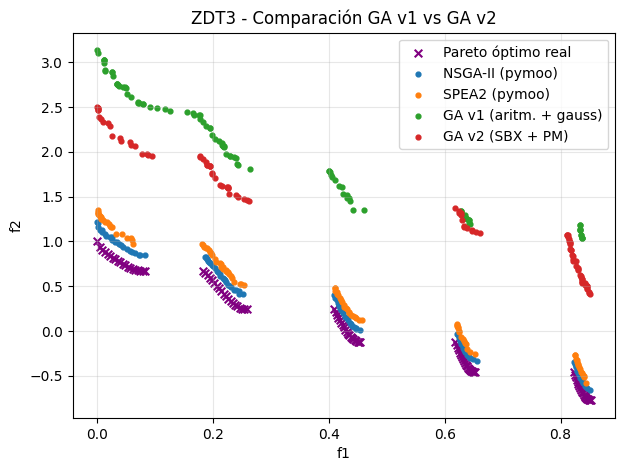

In [11]:
seed = 0

ag1 = evolve_my_mo(seed=seed)
ag2 = evolve_my_mo_v2(seed=seed)
ns = run_nsga2(seed=seed)
sp = run_spea2(seed=seed)

# Pareto óptimo real
pareto_optimal = problem.pareto_front()

plt.figure(figsize=(7, 5))

# Pareto real
plt.scatter(
    pareto_optimal[:, 0], pareto_optimal[:, 1],
    color="purple", marker="x", s=30,
    label="Pareto óptimo real"
)

# Algoritmos
plt.scatter(ns["F_nd"][:, 0], ns["F_nd"][:, 1], s=12, label="NSGA-II (pymoo)")
plt.scatter(sp["F_nd"][:, 0], sp["F_nd"][:, 1], s=12, label="SPEA2 (pymoo)")
plt.scatter(ag1["F_nd"][:, 0], ag1["F_nd"][:, 1], s=12, label="GA v1 (aritm. + gauss)")
plt.scatter(ag2["F_nd"][:, 0], ag2["F_nd"][:, 1], s=12, label="GA v2 (SBX + PM)")

plt.xlabel("f1")
plt.ylabel("f2")
plt.title("ZDT3 - Comparación GA v1 vs GA v2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Múltiples experimentos

In [12]:
rows = []

for seed in range(10):
    ag = evolve_my_mo(seed=seed)
    ag_2 = evolve_my_mo_v2(seed=seed)
    ns = run_nsga2(seed)
    sp = run_spea2(seed)

    ref_point = make_ref_point([
        ag["F_nd"],
        ag_2["F_nd"],
        ns["F_nd"],
        sp["F_nd"]
    ], margin=0.1)

    hv_ag,  spr_ag,  spa_ag  = calculate_metrics(ag["F_nd"], ref_point)
    hv_ag2, spr_ag2, spa_ag2 = calculate_metrics(ag_2["F_nd"], ref_point)
    hv_n,   spr_n,   spa_n   = calculate_metrics(ns["F_nd"], ref_point)
    hv_s,   spr_s,   spa_s   = calculate_metrics(sp["F_nd"], ref_point)

    rows.append({
        "seed": seed,
        "HV_AG": hv_ag, "SPR_AG": spr_ag, "SPA_AG": spa_ag,
        "HV_AG2": hv_ag2, "SPR_AG2": spr_ag2, "SPA_AG2": spa_ag2,
        "HV_NSGA2": hv_n, "SPR_NSGA2": spr_n, "SPA_NSGA2": spa_n,
        "HV_SPEA2": hv_s, "SPR_SPEA2": spr_s, "SPA_SPEA2": spa_s
    })

df2 = pd.DataFrame(rows)
df2

,seed,HV_AG,SPR_AG,SPA_AG,HV_AG2,SPR_AG2,SPA_AG2,HV_NSGA2,SPR_NSGA2,SPA_NSGA2,HV_SPEA2,SPR_SPEA2,SPA_SPEA2
0,0,1.502456,2.261655,0.011622,1.769060,2.252370,0.011512,2.937871,2.057442,0.013968,2.843063,2.115626,0.014077
1,1,1.360888,1.858921,0.014830,1.620519,1.932382,0.011172,2.736197,2.119788,0.014620,2.808261,2.087460,0.015027
2,2,1.197071,1.625258,0.019070,1.272319,1.516029,0.011120,2.404980,2.105969,0.014754,2.510867,2.008224,0.014863
3,3,1.294458,1.805729,0.018512,1.805203,2.177139,0.011368,3.081834,2.031596,0.014105,3.011296,2.079666,0.015616
4,4,1.476170,2.045481,0.016782,1.745940,2.433662,0.015513,3.153458,2.052401,0.015408,3.085921,2.069222,0.015139
5,5,1.277779,1.592488,0.011619,1.630050,1.856295,0.011448,2.850131,2.065700,0.014888,2.839623,2.084197,0.014903
6,6,1.388394,2.161880,0.017234,1.798632,1.996837,0.011074,3.105575,2.110584,0.015628,3.197532,2.093946,0.013738
7,7,1.393524,2.279126,0.017372,1.654275,2.272832,0.014357,2.880367,2.117134,0.016005,2.988667,2.025020,0.014874
8,8,1.146190,1.433238,0.014604,1.396986,1.927838,0.009887,2.449408,2.087438,0.013596,2.521752,2.092699,0.013133
9,9,1.307438,1.812864,0.012490,1.883059,1.834243,0.016706,3.063052,2.055565,0.014684,3.011090,2.090941,0.015584


In [13]:
summary_hv_spa = df2[[
    "HV_AG", "SPA_AG",
	"HV_AG2", "SPA_AG2",
    "HV_NSGA2", "SPA_NSGA2",
    "HV_SPEA2", "SPA_SPEA2"
]].agg(["mean", "std"])

summary_hv_spa

,HV_AG,SPA_AG,HV_AG2,SPA_AG2,HV_NSGA2,SPA_NSGA2,HV_SPEA2,SPA_SPEA2
mean,1.334437,0.015413,1.657604,0.012416,2.866287,0.014766,2.881807,0.014696
std,0.113169,0.002795,0.191845,0.002262,0.265414,0.000758,0.226611,0.000802


Best seed AG  = 0
Best seed AG2 = 9


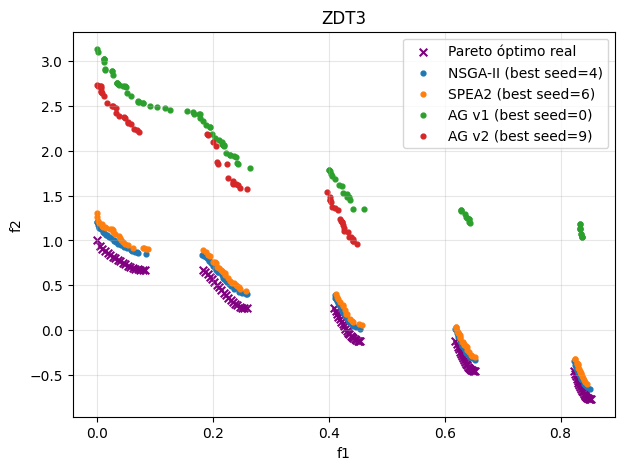

In [14]:
# BEST seed por HV para cada AG
best_seed_ag  = int(df2.loc[df2["HV_AG"].idxmax(), "seed"])
best_seed_ag2 = int(df2.loc[df2["HV_AG2"].idxmax(), "seed"])

print("Best seed AG  =", best_seed_ag)
print("Best seed AG2 =", best_seed_ag2)

# mejores runs (cada uno con su seed)
ag_best  = evolve_my_mo(seed=best_seed_ag)
ag2_best = evolve_my_mo_v2(seed=best_seed_ag2)

# best seed NSGA/SPEA por HV si existe en df2
best_seed_nsga = int(df2.loc[df2["HV_NSGA2"].idxmax(), "seed"]) if "HV_NSGA2" in df2.columns else best_seed_ag2
best_seed_spea = int(df2.loc[df2["HV_SPEA2"].idxmax(), "seed"]) if "HV_SPEA2" in df2.columns else best_seed_ag2

ns_best = run_nsga2(seed=best_seed_nsga)
sp_best = run_spea2(seed=best_seed_spea)

# Pareto óptimo real
pareto_optimal = problem.pareto_front()

plt.figure(figsize=(7,5))

# Pareto real
plt.scatter(
    pareto_optimal[:, 0], pareto_optimal[:, 1],
    color="purple", marker="x", s=30,
    label="Pareto óptimo real"
)

# Mejores frentes (por HV)
plt.scatter(ns_best["F_nd"][:,0], ns_best["F_nd"][:,1], s=12, label=f"NSGA-II (best seed={best_seed_nsga})")
plt.scatter(sp_best["F_nd"][:,0], sp_best["F_nd"][:,1], s=12, label=f"SPEA2 (best seed={best_seed_spea})")
plt.scatter(ag_best["F_nd"][:,0],  ag_best["F_nd"][:,1],  s=12, label=f"AG v1 (best seed={best_seed_ag})")
plt.scatter(ag2_best["F_nd"][:,0], ag2_best["F_nd"][:,1], s=12, label=f"AG v2 (best seed={best_seed_ag2})")

plt.xlabel("f1")
plt.ylabel("f2")
plt.title("ZDT3")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Conclusiones

Los resultados obtenidos en ZDT3 muestran que el algoritmo genético adaptado en su primera versión (AG v1), basado en cruce aritmético y mutación gaussiana, no consigue aproximarse bien al frente de Pareto, generando soluciones claramente alejadas de las obtenidas por NSGA-II y SPEA2. Aunque presenta una buena dispersión de soluciones, su hipervolumen es significativamente menor, lo que indica una peor convergencia. Al sustituir los operadores por SBX y mutación polinómica en la segunda versión (AG v2), se observa una mejora general en la calidad del frente, con valores de hipervolumen y espaciado más favorables. Aun así, AG v2 sigue quedando por detrás de NSGA-II y SPEA2, que muestran los mejores resultados tanto en convergencia como en estabilidad bajo el mismo presupuesto de evaluaciones.